In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
# Opções de visualização
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [16]:
# Célula 2: Ler o CSV (mesma pasta do notebook)
df = pd.read_csv("TSLA.csv")

# Garantir que 'Date' é datetime e manter ordem temporal
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Espiar os dados
display(df.head(10))
display(df.describe().T)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
1,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
3,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
4,2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000
5,2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000
6,2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500
7,2010-07-13,3.478,3.728,3.380,3.628,3.628,13400500
8,2010-07-14,3.588,4.030,3.552,3.968,3.968,20976000
9,2010-07-15,3.988,4.300,3.800,3.978,3.978,18699000


,count,mean,min,25%,50%,75%,max,std
Date,2843,2016-02-22 06:14:48.920154624,2010-07-01 00:00:00,2013-04-29 12:00:00,2016-02-24 00:00:00,2018-12-18 12:00:00,2021-10-14 00:00:00,NaN
Open,2843.0,105.868475,3.228,10.698,45.874001,65.021,891.380005,188.738974
High,2843.0,108.03137,3.326,11.026,46.493999,66.251999,900.400024,192.483055
Low,2843.0,103.555733,2.996,10.42,45.102001,64.015001,871.599976,184.638617
Close,2843.0,105.924597,3.16,10.727,45.916,65.275002,883.090027,188.836358
Adj Close,2843.0,105.924597,3.16,10.727,45.916,65.275002,883.090027,188.836358
Volume,2843.0,31415237.425255,592500.0,12510500.0,24815000.0,40120250.0,304694000.0,28418797.352952


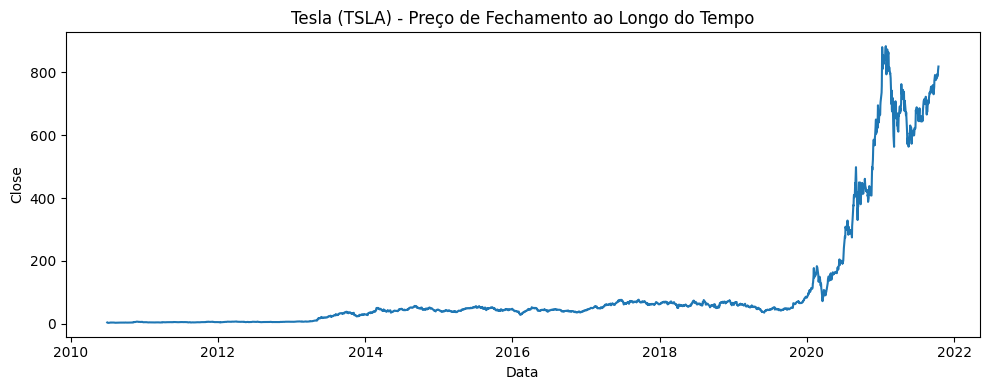

In [17]:
# Célula 3: Visualização do fechamento ao longo do tempo
plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Close"])
plt.title("Tesla (TSLA) - Preço de Fechamento ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Close")
plt.tight_layout()
plt.show()

In [18]:
# Célula 4: Features e alvo (classificação binária: sobe=1, cai/igual=0)

# Retorno percentual diário
df["return_1d"] = df["Close"].pct_change()

# Médias móveis
df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_10"] = df["Close"].rolling(10).mean()

# Momentum simples (diferença para 3 dias atrás)
df["mom_3"] = df["Close"] - df["Close"].shift(3)

# Volatilidade (desvio padrão do retorno em 5 dias)
df["vol_5"] = df["Close"].pct_change().rolling(5).std()

# Razão entre médias (sinal de cruzamento)
df["ma_ratio_5_10"] = df["ma_5"] / df["ma_10"]

# Alvo: 1 se o próximo fechamento for maior que o de hoje, senão 0
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Remove NaNs gerados por rolling/shift e a última linha (sem alvo válido)
df_model = df.dropna().copy()

# Seleção das features
features = [
    "Open", "High", "Low", "Close", "Adj Close", "Volume",
    "return_1d", "ma_5", "ma_10", "mom_3", "vol_5", "ma_ratio_5_10"
]
X = df_model[features]
y = df_model["Target"]

X.shape, y.shape

((2834, 12), (2834,))

In [19]:
# Célula 5: Separação treino/teste preservando a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=False
)

X_train.shape, X_test.shape


((2267, 12), (567, 12))

In [20]:
# Célula 6: Treinar o modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
# Célula 7: Avaliação (acurácia, relatório e matriz de confusão)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (teste): {acc:.4f}\n")

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia (teste): 0.4392

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.44      0.93      0.59       249
           1       0.50      0.05      0.10       318

    accuracy                           0.44       567
   macro avg       0.47      0.49      0.34       567
weighted avg       0.47      0.44      0.31       567

Matriz de Confusão:
 [[232  17]
 [301  17]]


In [22]:
# Célula 7: Avaliação (acurácia, relatório e matriz de confusão)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (teste): {acc:.4f}\n")

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))


Acurácia (teste): 0.4392

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.44      0.93      0.59       249
           1       0.50      0.05      0.10       318

    accuracy                           0.44       567
   macro avg       0.47      0.49      0.34       567
weighted avg       0.47      0.44      0.31       567

Matriz de Confusão:
 [[232  17]
 [301  17]]


,importance
ma_ratio_5_10,0.108827
return_1d,0.101688
Volume,0.098684
mom_3,0.095443
vol_5,0.093716
ma_10,0.076480
Open,0.075322
Low,0.073270
High,0.073081
ma_5,0.072314


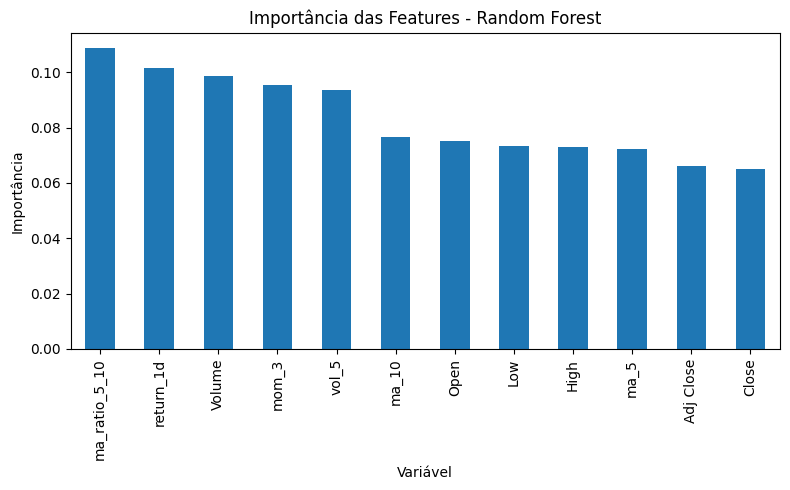

In [23]:
# Célula 8: Importância das features
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
display(importances.to_frame("importance"))

plt.figure(figsize=(8, 5))
importances.plot(kind="bar")
plt.title("Importância das Features - Random Forest")
plt.xlabel("Variável")
plt.ylabel("Importância")
plt.tight_layout()
plt.show()


In [24]:
# Célula 9: Amostras do conjunto de teste (para inspeção)
out = X_test.copy()
out["real"] = y_test.values
out["pred"] = y_pred
display(out.head(20))


,Open,High,Low,Close,Adj Close,Volume,return_1d,ma_5,ma_10,mom_3,vol_5,ma_ratio_5_10,real,pred
2276,51.009998,51.150002,50.377998,50.708000,50.708000,23793000,-0.005179,50.374400,48.607600,0.007999,0.018016,1.036348,1,0
2277,51.138000,51.992001,50.924000,51.636002,51.636002,35242000,0.018301,50.898401,49.109201,1.160000,0.016574,1.036433,0,0
2278,51.750000,52.430000,50.838001,51.136002,51.136002,34212000,-0.009683,50.985601,49.616001,0.164002,0.011789,1.027604,1,0
2279,51.341999,52.096001,50.900002,52.034000,52.034000,25115500,0.017561,51.297201,50.218201,1.326000,0.012946,1.021486,1,0
2280,51.834000,53.214001,51.632000,52.976002,52.976002,55364000,0.018104,51.698001,50.737401,1.340000,0.014016,1.018933,0,0
2281,46.700001,46.900002,45.110001,45.764000,45.764000,112091500,-0.136137,50.709201,50.541801,-5.372002,0.066915,1.003312,0,0
2282,45.383999,46.051998,44.450001,45.608002,45.608002,50138500,-0.003409,49.503601,50.201001,-6.425998,0.064605,0.986108,1,0
2283,45.417999,47.188000,45.206001,47.153999,47.153999,46366500,0.033897,48.707201,49.846401,-5.822003,0.069553,0.977146,1,0
2284,46.580002,48.672001,46.436001,48.452000,48.452000,40545000,0.027527,47.990801,49.644001,2.688000,0.070815,0.966699,0,1
2285,48.599998,49.335999,47.330002,48.321999,48.321999,45891000,-0.002683,47.060000,49.379001,2.713997,0.069197,0.953037,0,1


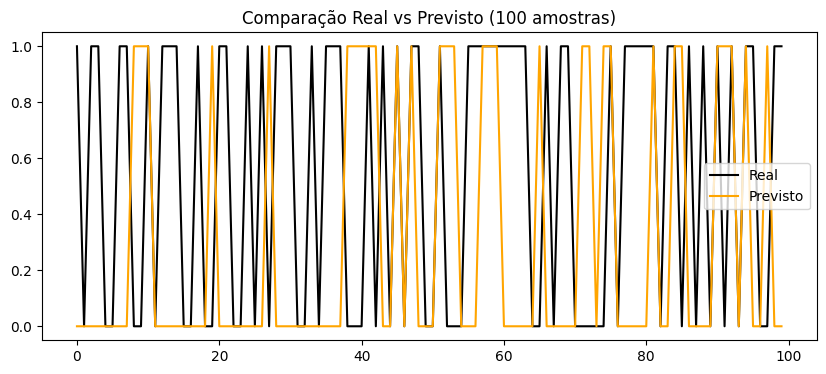

In [ ]:
# Gráfico simples comparando real vs previsão
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:100], label='Real', color='black')
plt.plot(y_pred[:100], label='Previsto', color='orange')
plt.title("Comparação Real vs Previsto (100 amostras)")
plt.legend()
plt.show()

# Real = Preto
# Previsto = Laranja


In [ ]:
# Células 1–3: carregam e exploram os dados (estatísticas e série temporal do fechamento).

"""Célula 4: cria features que capturam tendência (médias, razão de médias), momentum, volatilidade e retorno; 
   define o Target como “subiu no próximo dia (1) / não subiu (0)”."""

# Célula 5: separa treino/teste sem embaralhar (série temporal).

# Célula 6: treina RandomForest (robusto e simples para tabular).

# Célula 7: mede desempenho (acurácia, relatório, matriz de confusão).

# Célula 8: mostra quais variáveis pesaram mais.

# Célula 9: lista exemplos do teste com rótulo real vs previsão.